In [2]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from datetime import timedelta

# Download AAPL stock data since inception
data = yf.download('AAPL', start='1980-12-12', auto_adjust=True)
data = data[['Close']].dropna()

# Set datetime index
data.index = pd.to_datetime(data.index)

# Resample monthly for smoother forecasting
monthly_data = data['Close'].resample('M').mean()

# Prepare time variable for linear regression
monthly_data = monthly_data.reset_index()
monthly_data['Time'] = np.arange(len(monthly_data))

monthly_data.head(-5)

[*********************100%***********************]  1 of 1 completed
C:\Users\medha\AppData\Local\Temp\ipykernel_27616\1317707316.py:18: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_data = data['Close'].resample('M').mean()


Ticker,Date,AAPL,Time
0,1980-12-31,0.104282,0
1,1981-01-31,0.108435,1
2,1981-02-28,0.090462,2
3,1981-03-31,0.085075,3
4,1981-04-30,0.093265,4
...,...,...,...
527,2024-11-30,226.943402,527
528,2024-12-31,248.440912,528
529,2025-01-31,233.757180,529
530,2025-02-28,237.864737,530


<Figure size 1200x500 with 0 Axes>

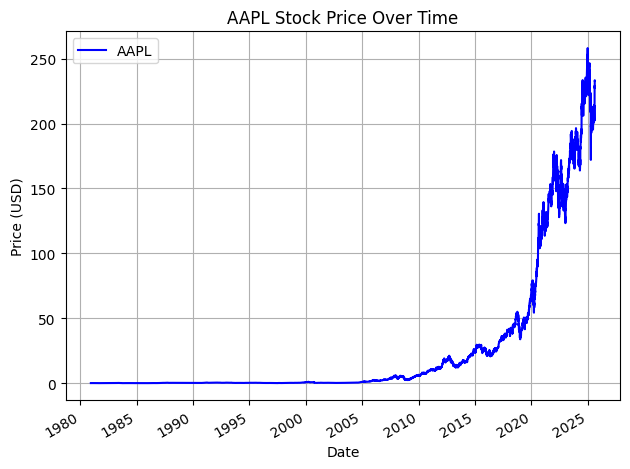

In [3]:
# Plot the stock price over the entire period
plt.figure(figsize=(12, 5))
data['Close'].plot(label='AAPL Stock Price', color='blue')

# Add labels and title
plt.title('AAPL Stock Price Over Time')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

C:\Users\medha\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
C:\Users\medha\AppData\Local\Temp\ipykernel_27616\1756373262.py:25: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  lr_forecast_dates = pd.date_range(start=df.index[-1] + pd.DateOffset(months=1), periods=60, freq='M')
C:\Users\medha\AppData\Local\Temp\ipykernel_27616\1756373262.py:34: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  full_index = pd.date_range(start=df.index[0], end=lr_forecast_dates[-1], freq='M')


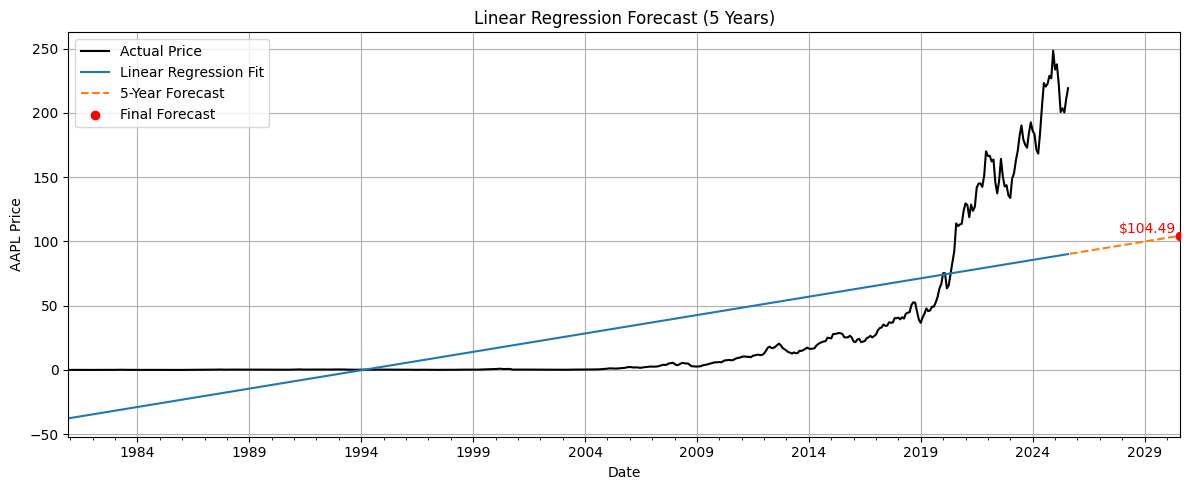

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

# Copy and prepare the base DataFrame
df = monthly_data.copy()
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)

# -------------------------------
# 1. Linear Regression
# -------------------------------
X = df[['Time']]
y = df['AAPL']

# Fit model and store predictions on training data
linear_model = LinearRegression().fit(X, y)
df['LR_Predicted'] = linear_model.predict(X)

# Forecast future 5 years (60 months)
last_time = int(df['Time'].iloc[-1])
future_time = np.arange(last_time + 1, last_time + 61)
lr_forecast = linear_model.predict(future_time.reshape(-1, 1))
lr_forecast_dates = pd.date_range(start=df.index[-1] + pd.DateOffset(months=1), periods=60, freq='M')

# Combine forecast into new DataFrame for plotting
forecast_df = pd.DataFrame({
    'Date': lr_forecast_dates,
    'Forecast': lr_forecast
}).set_index('Date')

# Extend x-axis index range for smooth visualization
full_index = pd.date_range(start=df.index[0], end=lr_forecast_dates[-1], freq='M')
df = df.reindex(full_index)

# Plotting
plt.figure(figsize=(12, 5))
df['AAPL'].plot(label='Actual Price', color='black')
df['LR_Predicted'].plot(label='Linear Regression Fit')
forecast_df['Forecast'].plot(label='5-Year Forecast', linestyle='--')

# Plot final forecast point
final_date = lr_forecast_dates[-1]
final_value = lr_forecast[-1]
plt.scatter(final_date, final_value, color='red', zorder=5, label='Final Forecast')

# Add dollar label to the left of the red point
plt.text(final_date - pd.DateOffset(months=2), final_value,
         f"${final_value:.2f}", color='red', fontsize=10,
         verticalalignment='bottom', horizontalalignment='right')

# Final touches
plt.xlim([df.index[0], lr_forecast_dates[-1]])
plt.title('Linear Regression Forecast (5 Years)')
plt.xlabel('Date')
plt.ylabel('AAPL Price')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [5]:
from sklearn.metrics import mean_squared_error, r2_score

# Compute predictions on the training set
y_true = y
y_pred = linear_model.predict(X)

# Basic evaluation metrics
mse = mean_squared_error(y_true, y_pred)
r2 = r2_score(y_true, y_pred)

# AIC and BIC
n = len(y_true)
k = X.shape[1]  # number of predictors
rss = np.sum((y_true - y_pred) ** 2)
aic = n * np.log(rss / n) + 2 * (k + 1)
bic = n * np.log(rss / n) + np.log(n) * (k + 1)

# Display results
print(f"MSE: {mse:.4f}")
print(f"R²: {r2:.4f}")
print(f"AIC: {aic:.2f}")
print(f"BIC: {bic:.2f}")

MSE: 1593.5749
R²: 0.4616
AIC: 3963.70
BIC: 3972.27


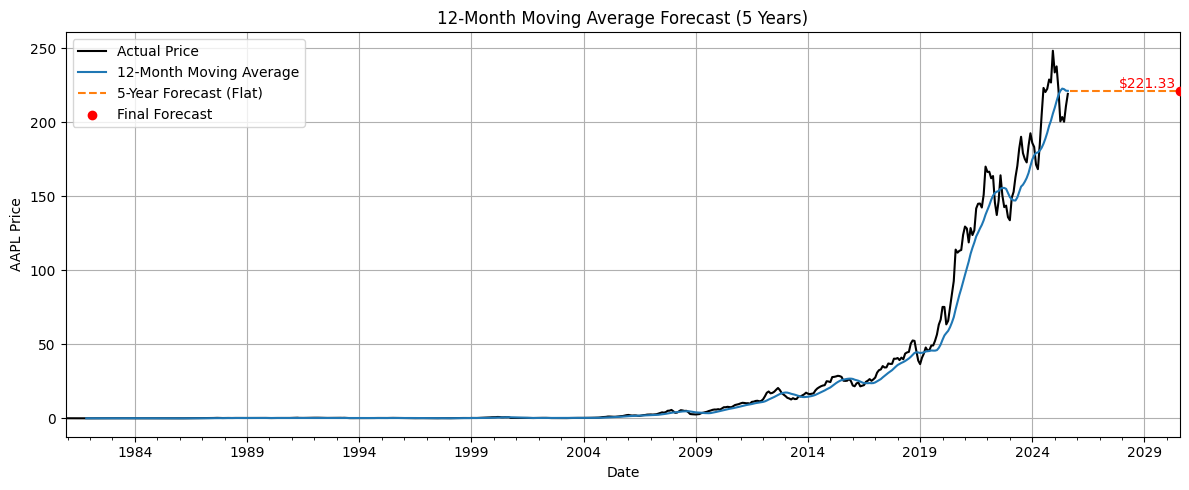

In [6]:
# -------------------------------
# 2. Moving Average (12-month)
# -------------------------------
df['MA_12'] = df['AAPL'].rolling(window=12).mean()

# Forecast: extend last MA value for 60 months
ma_last_value = df['MA_12'].dropna().iloc[-1]
ma_forecast = [ma_last_value] * 60
ma_forecast_df = pd.DataFrame({
    'Date': lr_forecast_dates,
    'Forecast': ma_forecast
}).set_index('Date')

# Plotting
plt.figure(figsize=(12, 5))
df['AAPL'].plot(label='Actual Price', color='black')
df['MA_12'].plot(label='12-Month Moving Average')
ma_forecast_df['Forecast'].plot(label='5-Year Forecast (Flat)', linestyle='--')

# Final forecast point + label
plt.scatter(lr_forecast_dates[-1], ma_last_value, color='red', zorder=5, label='Final Forecast')
plt.text(lr_forecast_dates[-1] - pd.DateOffset(months=2), ma_last_value,
         f"${ma_last_value:.2f}", color='red', fontsize=10,
         verticalalignment='bottom', horizontalalignment='right')

plt.xlim([df.index[0], lr_forecast_dates[-1]])
plt.title('12-Month Moving Average Forecast (5 Years)')
plt.xlabel('Date')
plt.ylabel('AAPL Price')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [7]:
# Safely create moving average before reindexing modifies df
df_ma = monthly_data.copy()
df_ma['Date'] = pd.to_datetime(df_ma['Date'])
df_ma.set_index('Date', inplace=True)
df_ma['MA_12'] = df_ma['AAPL'].rolling(window=12).mean()


from sklearn.metrics import mean_squared_error, r2_score

valid_mask = df_ma['MA_12'].notna()
y_true_ma = df_ma.loc[valid_mask, 'AAPL']
y_pred_ma = df_ma.loc[valid_mask, 'MA_12']

mse_ma = mean_squared_error(y_true_ma, y_pred_ma)
r2_ma = r2_score(y_true_ma, y_pred_ma)

n_ma = len(y_true_ma)
k_ma = 1  # one effective predictor (historical average)
rss_ma = np.sum((y_true_ma - y_pred_ma) ** 2)
aic_ma = n_ma * np.log(rss_ma / n_ma) + 2 * (k_ma + 1)
bic_ma = n_ma * np.log(rss_ma / n_ma) + np.log(n_ma) * (k_ma + 1)

print(f"MSE (Moving Average): {mse_ma:.4f}")
print(f"R² (Moving Average): {r2_ma:.4f}")
print(f"AIC (Moving Average): {aic_ma:.2f}")
print(f"BIC (Moving Average): {bic_ma:.2f}")

MSE (Moving Average): 60.6448
R² (Moving Average): 0.9798
AIC (Moving Average): 2163.25
BIC (Moving Average): 2171.78


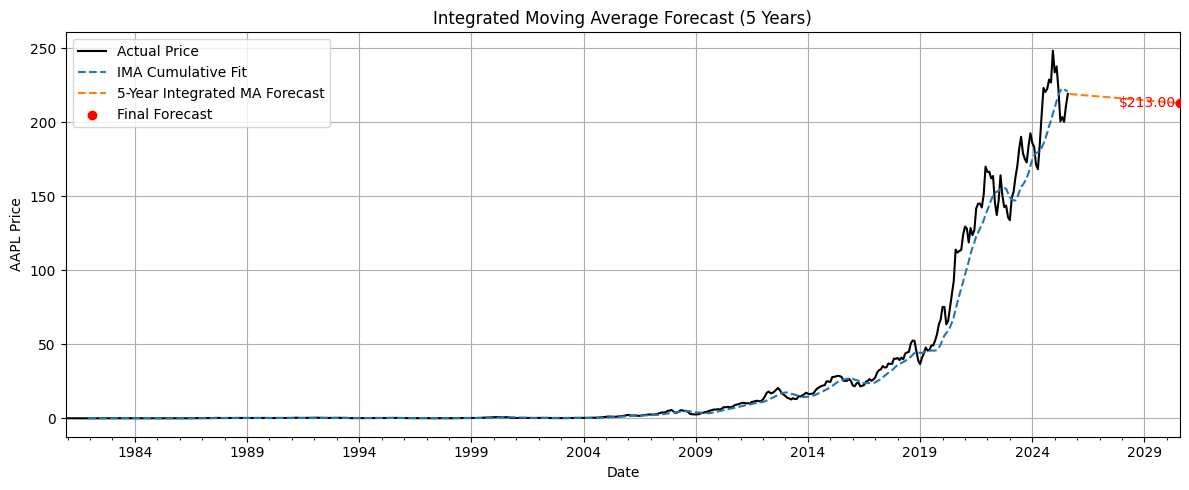

In [8]:
# -------------------------------
# 3. Integrated Moving Average (IMA)
# -------------------------------
df['Diff'] = df['AAPL'].diff()
df['IMA_12'] = df['Diff'].rolling(window=12).mean()

# Reconstruct "fit" using cumsum of rolling average
ima_fit = df['IMA_12'].cumsum() + df['AAPL'].dropna().iloc[0]
df['IMA_Reconstructed'] = ima_fit

# Forecast future values by extending the last rolling average
ima_last_avg = df['IMA_12'].dropna().iloc[-1]
ima_forecast = [ima_last_avg] * 60
ima_integrated = df['AAPL'].dropna().iloc[-1] + np.cumsum(ima_forecast)

ima_forecast_df = pd.DataFrame({
    'Date': lr_forecast_dates,
    'Forecast': ima_integrated
}).set_index('Date')

# Plotting
plt.figure(figsize=(12, 5))
df['AAPL'].plot(label='Actual Price', color='black')
df['IMA_Reconstructed'].plot(label='IMA Cumulative Fit', linestyle='--')
ima_forecast_df['Forecast'].plot(label='5-Year Integrated MA Forecast', linestyle='--')

# Final forecast point + label
plt.scatter(lr_forecast_dates[-1], ima_integrated[-1], color='red', zorder=5, label='Final Forecast')
plt.text(lr_forecast_dates[-1] - pd.DateOffset(months=2), ima_integrated[-1],
         f"${ima_integrated[-1]:.2f}", color='red', fontsize=10,
         verticalalignment='center', horizontalalignment='right')

plt.xlim([df.index[0], lr_forecast_dates[-1]])
plt.title('Integrated Moving Average Forecast (5 Years)')
plt.xlabel('Date')
plt.ylabel('AAPL Price')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [9]:
# Make a fresh copy to avoid issues from reindexing
df_ima = monthly_data.copy()
df_ima['Date'] = pd.to_datetime(df_ima['Date'])
df_ima.set_index('Date', inplace=True)

# Compute IMA components
df_ima['Diff'] = df_ima['AAPL'].diff()
df_ima['IMA_12'] = df_ima['Diff'].rolling(window=12).mean()

# Reconstruct series using cumulative sum of IMA rolling average
ima_fit = df_ima['IMA_12'].cumsum() + df_ima['AAPL'].dropna().iloc[0]
df_ima['IMA_Reconstructed'] = ima_fit

from sklearn.metrics import mean_squared_error, r2_score

valid_mask = df_ima['IMA_Reconstructed'].notna() & df_ima['AAPL'].notna()
y_true_ima = df_ima.loc[valid_mask, 'AAPL']
y_pred_ima = df_ima.loc[valid_mask, 'IMA_Reconstructed']

mse_ima = mean_squared_error(y_true_ima, y_pred_ima)
r2_ima = r2_score(y_true_ima, y_pred_ima)

n_ima = len(y_true_ima)
k_ima = 1
rss_ima = np.sum((y_true_ima - y_pred_ima) ** 2)
aic_ima = n_ima * np.log(rss_ima / n_ima) + 2 * (k_ima + 1)
bic_ima = n_ima * np.log(rss_ima / n_ima) + np.log(n_ima) * (k_ima + 1)

print(f"MSE (IMA): {mse_ima:.4f}")
print(f"R² (IMA): {r2_ima:.4f}")
print(f"AIC (IMA): {aic_ima:.2f}")
print(f"BIC (IMA): {bic_ima:.2f}")

MSE (IMA): 60.6794
R² (IMA): 0.9799
AIC (IMA): 2159.44
BIC (IMA): 2167.97


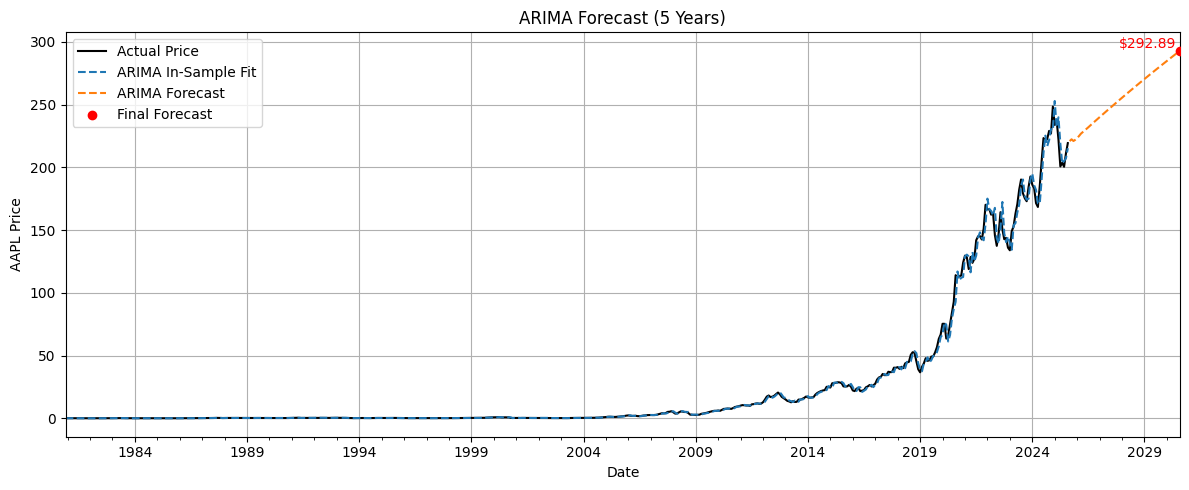

In [10]:
# -------------------------------
# 4. ARIMA Forecast
# -------------------------------
arima_series = df['AAPL'].dropna()
arima_model = ARIMA(arima_series, order=(5, 1, 2)).fit()

# Get fitted values (in-sample prediction)
df['ARIMA_Fit'] = arima_model.fittedvalues

# Forecast future
arima_forecast = arima_model.forecast(steps=60)
arima_forecast_df = pd.DataFrame({
    'Date': lr_forecast_dates,
    'Forecast': arima_forecast
}).set_index('Date')

# Plotting
plt.figure(figsize=(12, 5))
df['AAPL'].plot(label='Actual Price', color='black')
df['ARIMA_Fit'].plot(label='ARIMA In-Sample Fit', linestyle='--')
arima_forecast_df['Forecast'].plot(label='ARIMA Forecast', linestyle='--')

# Final forecast point + label
plt.scatter(lr_forecast_dates[-1], arima_forecast.iloc[-1], color='red', zorder=5, label='Final Forecast')
plt.text(lr_forecast_dates[-1] - pd.DateOffset(months=2), arima_forecast.iloc[-1],
         f"${arima_forecast.iloc[-1]:.2f}", color='red', fontsize=10,
         verticalalignment='bottom', horizontalalignment='right')

plt.xlim([df.index[0], lr_forecast_dates[-1]])
plt.title('ARIMA Forecast (5 Years)')
plt.xlabel('Date')
plt.ylabel('AAPL Price')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [16]:
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error, r2_score

# Use a fresh copy of monthly_data
df_arima = monthly_data.copy()
df_arima['Date'] = pd.to_datetime(df_arima['Date'])
df_arima.set_index('Date', inplace=True)

# Prepare ARIMA model
arima_series = df_arima['AAPL'].dropna()
arima_model = ARIMA(arima_series, order=(5, 1, 2)).fit()

# Get in-sample fitted values
df_arima['ARIMA_Fit'] = arima_model.fittedvalues

# Drop NA values created due to differencing
valid_mask = df_arima['ARIMA_Fit'].notna()
y_true_arima = df_arima.loc[valid_mask, 'AAPL']
y_pred_arima = df_arima.loc[valid_mask, 'ARIMA_Fit']

mse_arima = mean_squared_error(y_true_arima, y_pred_arima)
r2_arima = r2_score(y_true_arima, y_pred_arima)

n_arima = len(y_true_arima)
k_arima = 5 + 1 + 2  # AR + I + MA
rss_arima = np.sum((y_true_arima - y_pred_arima) ** 2)
aic_arima = n_arima * np.log(rss_arima / n_arima) + 2 * (k_arima + 1)
bic_arima = n_arima * np.log(rss_arima / n_arima) + np.log(n_arima) * (k_arima + 1)

# Display results
print(f"MSE (ARIMA): {mse_arima:.4f}")
print(f"R² (ARIMA): {r2_arima:.4f}")
print(f"AIC (ARIMA): {aic_arima:.2f}")
print(f"BIC (ARIMA): {bic_arima:.2f}")

c:\Users\medha\miniconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
c:\Users\medha\miniconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
c:\Users\medha\miniconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)


MSE (ARIMA): 11.5504
R² (ARIMA): 0.9958
AIC (ARIMA): 1322.10
BIC (ARIMA): 1360.61


c:\Users\medha\miniconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


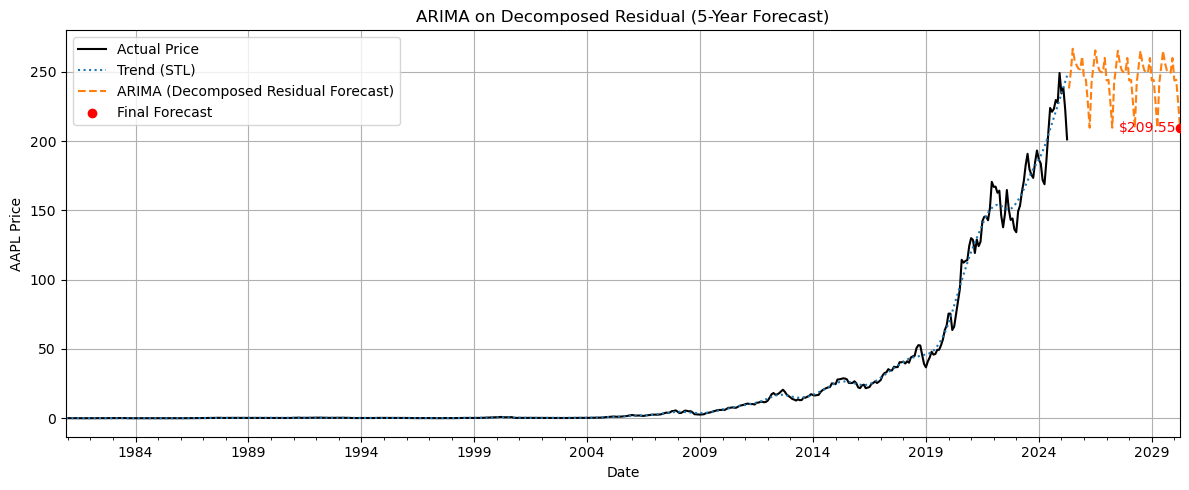

In [17]:
from statsmodels.tsa.seasonal import STL
from statsmodels.tsa.arima.model import ARIMA

# -------------------------------
# 6. ARIMA on Residual Component
# -------------------------------

# Drop missing values (for rolling & decomposition)
series = df['AAPL'].dropna()

# STL decomposition (seasonal-trend decomposition using Loess)
stl = STL(series, period=12)  # assuming monthly data with yearly seasonality
result = stl.fit()
df['Trend'] = result.trend
df['Seasonal'] = result.seasonal
df['Residual'] = result.resid

# Fit ARIMA on residual
arima_resid_model = ARIMA(df['Residual'].dropna(), order=(5, 0, 2)).fit()
resid_forecast = arima_resid_model.forecast(steps=60)

# Extend trend and seasonal components
trend_forecast = [df['Trend'].dropna().iloc[-1]] * 60
seasonal_pattern = df['Seasonal'].dropna()[-12:].values
seasonal_forecast = np.tile(seasonal_pattern, 5)  # repeats the seasonal pattern 5 times (60 months)

# Final forecast = residual + trend + seasonal
final_forecast = resid_forecast.values + np.array(trend_forecast) + np.array(seasonal_forecast)
arima_decomp_df = pd.DataFrame({
    'Date': lr_forecast_dates,
    'Forecast': final_forecast
}).set_index('Date')

# Plotting
plt.figure(figsize=(12, 5))
df['AAPL'].plot(label='Actual Price', color='black')
df['Trend'].plot(label='Trend (STL)', linestyle=':')
arima_decomp_df['Forecast'].plot(label='ARIMA (Decomposed Residual Forecast)', linestyle='--')

# Final forecast point + label
plt.scatter(lr_forecast_dates[-1], final_forecast[-1], color='red', zorder=5, label='Final Forecast')
plt.text(lr_forecast_dates[-1] - pd.DateOffset(months=2), final_forecast[-1],
         f"${final_forecast[-1]:.2f}", color='red', fontsize=10,
         verticalalignment='center', horizontalalignment='right')

plt.xlim([df.index[0], lr_forecast_dates[-1]])
plt.title('ARIMA on Decomposed Residual (5-Year Forecast)')
plt.xlabel('Date')
plt.ylabel('AAPL Price')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [18]:
from statsmodels.tsa.seasonal import STL
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error, r2_score

# Use clean copy of monthly data
df_decomp = monthly_data.copy()
df_decomp['Date'] = pd.to_datetime(df_decomp['Date'])
df_decomp.set_index('Date', inplace=True)

# Perform STL decomposition
series = df_decomp['AAPL'].dropna()
stl = STL(series, period=12)
result = stl.fit()

df_decomp['Trend'] = result.trend
df_decomp['Seasonal'] = result.seasonal
df_decomp['Residual'] = result.resid

# Fit ARIMA model on the residual component
resid_series = df_decomp['Residual'].dropna()
arima_resid_model = ARIMA(resid_series, order=(5, 0, 2)).fit()

# In-sample fitted residuals
fitted_resid = arima_resid_model.fittedvalues
aligned_index = resid_series.index[-len(fitted_resid):]  # ensure index alignment
df_decomp.loc[aligned_index, 'Residual_Fit'] = fitted_resid

# Reconstruct the predicted series using trend + seasonal + fitted residual
df_decomp['ARIMA_STL_Reconstructed'] = df_decomp['Trend'] + df_decomp['Seasonal'] + df_decomp['Residual_Fit']

# Only use rows where all components are present
valid_mask = df_decomp[['AAPL', 'ARIMA_STL_Reconstructed']].notna().all(axis=1)
y_true_decomp = df_decomp.loc[valid_mask, 'AAPL']
y_pred_decomp = df_decomp.loc[valid_mask, 'ARIMA_STL_Reconstructed']

mse_decomp = mean_squared_error(y_true_decomp, y_pred_decomp)
r2_decomp = r2_score(y_true_decomp, y_pred_decomp)

n_decomp = len(y_true_decomp)
k_decomp = 5 + 2  # AR + MA (no differencing)
rss_decomp = np.sum((y_true_decomp - y_pred_decomp) ** 2)
aic_decomp = n_decomp * np.log(rss_decomp / n_decomp) + 2 * (k_decomp + 1)
bic_decomp = n_decomp * np.log(rss_decomp / n_decomp) + np.log(n_decomp) * (k_decomp + 1)

print(f"MSE (STL+ARIMA): {mse_decomp:.4f}")
print(f"R² (STL+ARIMA): {r2_decomp:.4f}")
print(f"AIC (STL+ARIMA): {aic_decomp:.2f}")
print(f"BIC (STL+ARIMA): {bic_decomp:.2f}")

c:\Users\medha\miniconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
c:\Users\medha\miniconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
c:\Users\medha\miniconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)


MSE (STL+ARIMA): 3.4374
R² (STL+ARIMA): 0.9987
AIC (STL+ARIMA): 674.11
BIC (STL+ARIMA): 708.33


In [19]:
# Target date
target_date = pd.Timestamp('2025-04-15')

# Function to get nearest forecast value
def get_nearest_forecast_value(forecast_df, date):
    forecast_df = forecast_df.sort_index()  # Ensure index is sorted
    idx = forecast_df.index.get_indexer([date], method='nearest')[0]
    return forecast_df.iloc[idx]['Forecast']

# Gather predictions from each model
predictions = {
    'Linear Regression': get_nearest_forecast_value(forecast_df, target_date),
    'Moving Average': get_nearest_forecast_value(ma_forecast_df, target_date),
    'Integrated MA': get_nearest_forecast_value(ima_forecast_df, target_date),
    'ARIMA': get_nearest_forecast_value(arima_forecast_df, target_date),
    'ARIMA (Decomposed Residual)': get_nearest_forecast_value(arima_decomp_df, target_date)
}

# Display results
for model, value in predictions.items():
    print(f"{model}: ${value:.2f}")

Linear Regression: $86.09
Moving Average: $221.84
Integrated MA: $203.88
ARIMA: $193.90
ARIMA (Decomposed Residual): $237.89


In [20]:
# Target date
target_date = pd.Timestamp('2025-04-15')

# Function to get nearest forecast value
def get_nearest_forecast_value(forecast_df, date):
    forecast_df = forecast_df.sort_index()  # Ensure index is sorted
    idx = forecast_df.index.get_indexer([date], method='nearest')[0]
    return forecast_df.iloc[idx]['Forecast']

# Gather predictions from each model
predictions = {
    'Linear Regression': (202.14 - get_nearest_forecast_value(forecast_df, target_date)),
    'Moving Average': (202.14 - get_nearest_forecast_value(ma_forecast_df, target_date)),
    'Integrated MA': (202.14 - get_nearest_forecast_value(ima_forecast_df, target_date)),
    'ARIMA': (202.14 - get_nearest_forecast_value(arima_forecast_df, target_date)),
    'ARIMA (Decomposed Residual)': (202.14 - get_nearest_forecast_value(arima_decomp_df, target_date))
}

# Display results
for model, value in predictions.items():
    print(f"{model}: ${value:.2f}")

Linear Regression: $116.05
Moving Average: $-19.70
Integrated MA: $-1.74
ARIMA: $8.24
ARIMA (Decomposed Residual): $-35.75
